## Retrieval augmented generation
 
In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution. 

This is useful if we want to ask question about specific documents (e.g., Web pages, our PDFs, a set of videos, etc). 

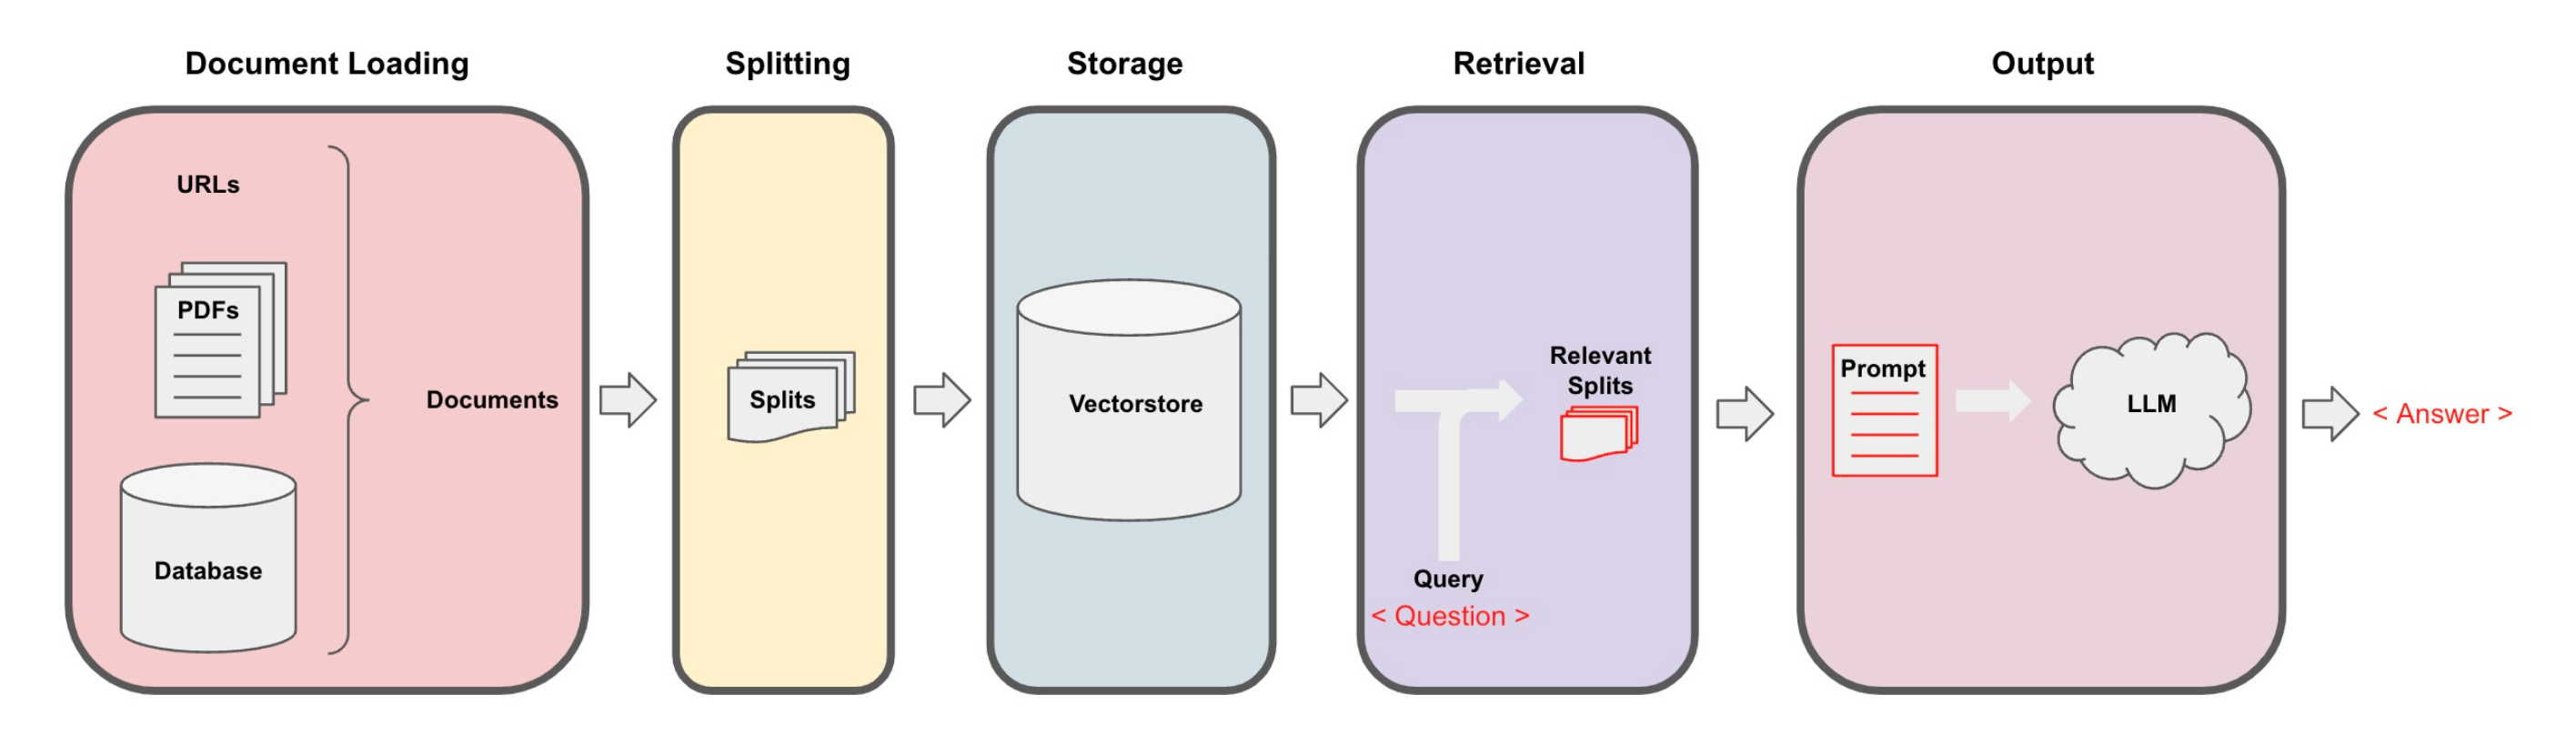

In [ ]:
# !pip install langchain langchain_community langchainhub chromadb

## LLM Configuration

In [1]:
from langchain_community.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = Ollama(
        model="llama3",
        verbose=False,
        callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    )

## Document loading

In [2]:
from langchain_community.document_loaders import WebBaseLoader


In [3]:
loader = WebBaseLoader("https://www.aceso.no/about")

In [4]:
page_content = loader.load()

In [5]:
print(page_content[0].page_content[:500])

About - AcesoHomeServicesWelfare TechCloud ManagmentAI/ML AnalyticsCloud ManagementCritical InfrastructureProfessional ServicesPlatformsHealthcare Platformstack8sIoT PlatformAbout UsBlogENGNORGet in touchOur mission is to modernise healthcare with AI AnalyticsJoin our teamAbout Aceso AnalyticsAceso Analytics is your partner in modernizing healthcare, advancing sustainability, and mastering analytics. Our expertise lies in:Hybrid Cloud SolutionsSeamlessly blending on-premises and cloud technology


## Splitting

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=2)
all_splits = text_splitter.split_documents(page_content)
print(f"Splited in {len(all_splits)} parts")

Splited in 17 parts


## Storage

In [8]:
from langchain_community.embeddings import OllamaEmbeddings

embeddings = (
    OllamaEmbeddings(model='nomic-embed-text')
)

Embedding models take text, images, or other data and transform them into numerical representations

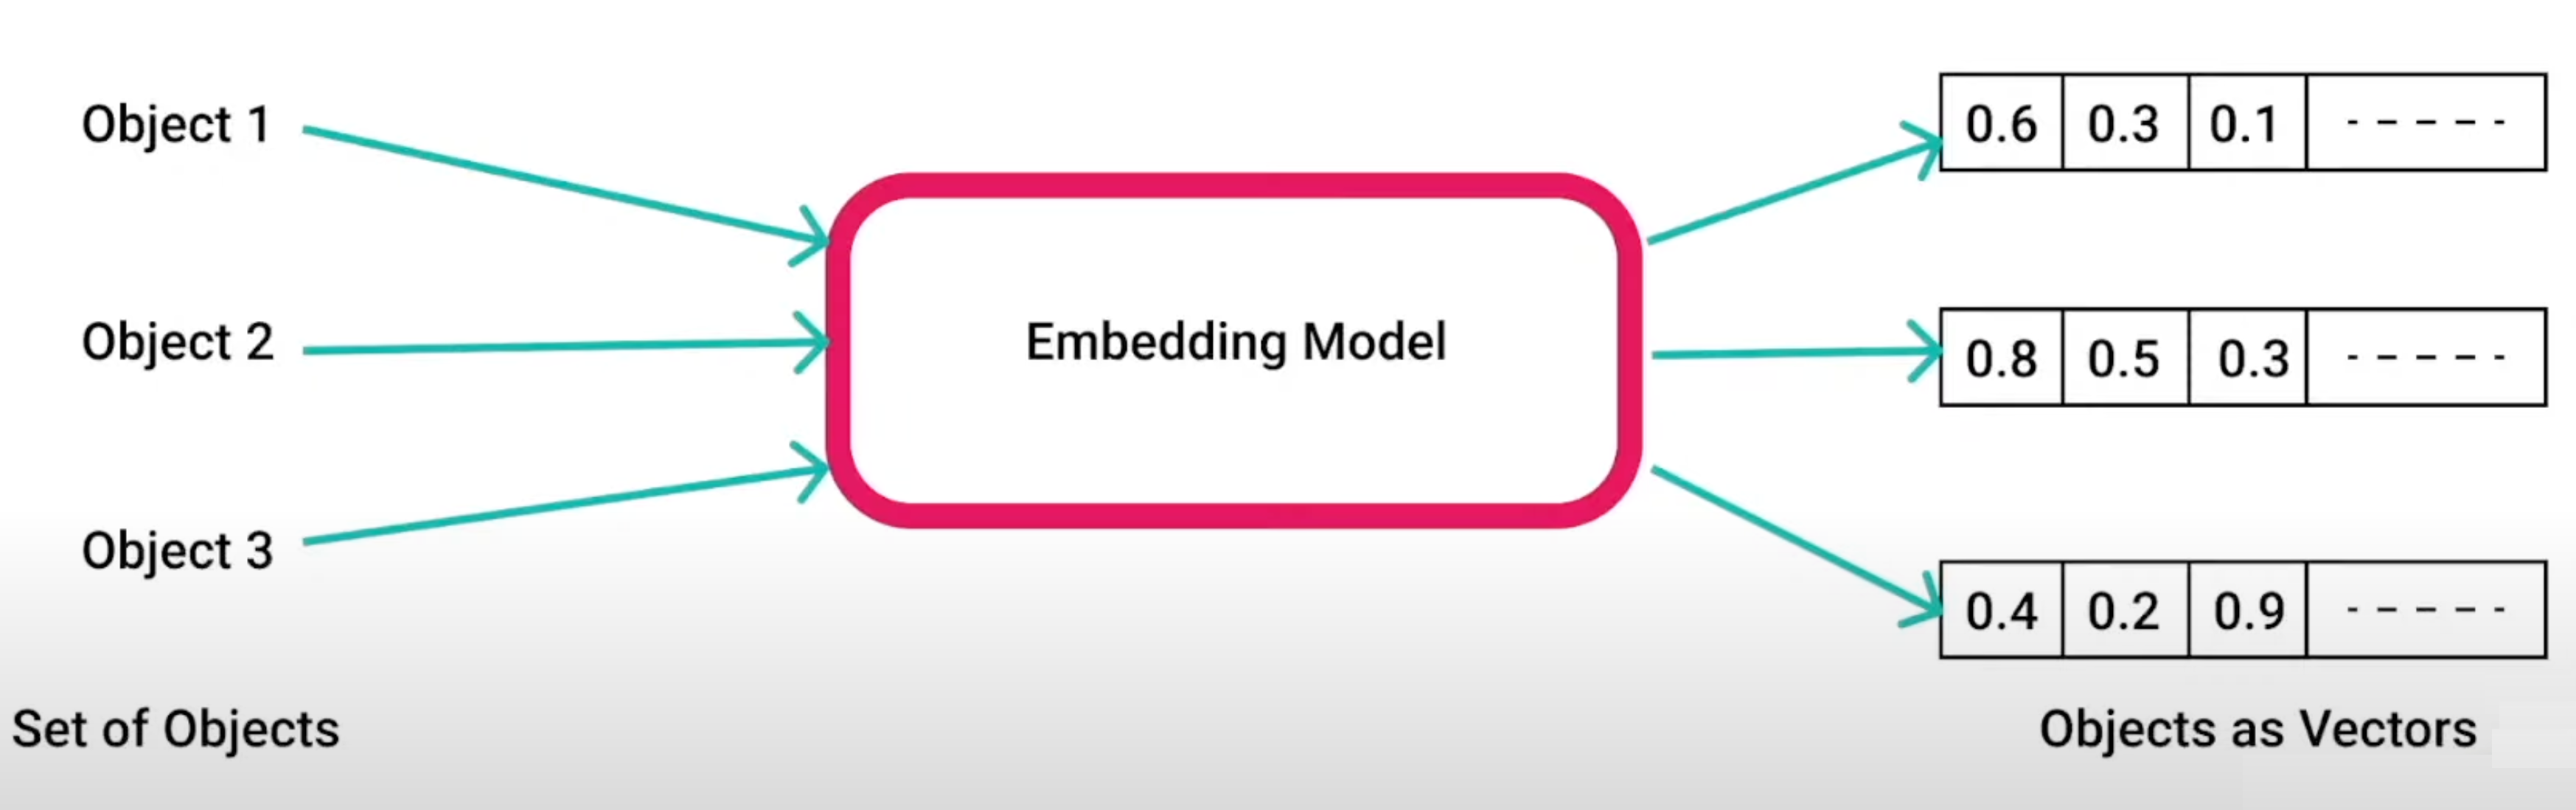

In [9]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(
        documents=all_splits, embedding=embeddings
    )

## Retrieval

In [10]:
from langchain.chains import RetrievalQA


In [11]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever()
)

In [12]:
question = "What is Aceso Analytics?"
result = qa_chain.invoke({"query": question})

Aceso Analytics is a company that provides analytics services to help modernize healthcare and advance sustainability, with expertise in areas such as hybrid cloud solutions and mastering analytics.

## Output

In [13]:
from langchain.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [14]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [15]:
question = "Why Choose Aceso Analytics?"

In [16]:
result = qa_chain({"query": question})
print(result["result"])

/Users/erik/Develop/rag/venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Aceso Analytics is your partner in modernizing healthcare, advancing sustainability, and mastering analytics. They offer hybrid cloud solutions and proven expertise in this field. Contact them today for innovative solutions.

Thanks for asking!Aceso Analytics is your partner in modernizing healthcare, advancing sustainability, and mastering analytics. They offer hybrid cloud solutions and proven expertise in this field. Contact them today for innovative solutions.

Thanks for asking!


In [17]:
result = qa_chain({"query": "Do you have free consultation?"})
print(result["result"])

Yes, according to the provided context, it appears that getting a free consultation is an option. You can get in touch with their team members at any time to speak with a professional and receive tailored solutions for your business. Thanks for asking!Yes, according to the provided context, it appears that getting a free consultation is an option. You can get in touch with their team members at any time to speak with a professional and receive tailored solutions for your business. Thanks for asking!
